In [1]:
#-*- coding:utf-8 -*-

# pandas import 
import pandas as pd

# numpy import
import numpy as np

# Graph lib import 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

# heatmap
import seaborn as sns

# 피어슨 상관계수 
import scipy.stats as stats

# OLS Regression
import statsmodels.formula.api as smf

# Logistic Regression
import statsmodels.api as sm

# pre-required pip3 install factor-analyzer
from factor_analyzer import FactorAnalyzer

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


# 각 열, 응답문항에 대하여 집계 한 데이터 return
def q13a_agg_col(col_name, agg_type, each_cnt, df, surfix):
    data = {}
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'            # lpad 0, 2 length
        col_nm = col_name + col_idx 
        data[col_nm + '_' + surfix] = df[col_nm].groupby(df[col_nm]).agg(agg_type)
    return data

# cronbach alpha 
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
        mean_r = np.mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha


# 피어슨 상관계수를 구한뒤 dataFrame 으로 변환한다.
def pearson_frame(index_col, data_frame, each_cnt, col_list):
    data = {}
    for i in range(1, each_cnt):
        pear_val = stats.pearsonr(data_frame.corr()[index_col], data_frame.corr()[col_list[i-1]])
        data[col_list[i-1]] = pear_val
        
    res_data = pd.DataFrame.from_dict(data)
    res_data = res_data.rename(index={0 : '피어슨 상관계수 r', 1 : 'p-value'})
    return res_data

# raw data 5점 척도 변환

# one hot encoding 
def change_one_hot(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x <= 4 else 1)
    return convert_df 


def change_one_hot_by_median(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        
        # 중앙값 기준으로 -> 중앙값보다 작거나 같으면 0, 중앙값보다 크면 1 이다.
        this_median = convert_df[col_nm].mode()
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x < int(this_median) else 1)
    return convert_df

def change_one_hot_by_median_col(origin_df, col_name):
    convert_df = origin_df
    convert_df[col_name] = convert_df[col_name].apply(lambda x : 0 if x <= 4 else 1)
    return convert_df

def change_one_hot_by_mode(origin_df, each_cnt, prefix):
    convert_df = origin_df
    for i in range(1, each_cnt):
        col_idx = f'{i:02}'
        col_nm = prefix + col_idx
        
        # 최빈값 기준으로 -> 최빈값보다 작으면 0, 최빈값보다 크면 1 이다.
        this_median = convert_df[col_nm].mode()
        convert_df[col_nm] = convert_df[col_nm].apply(lambda x : 0 if x < int(this_median) else 1)
    return convert_df


# view to heatmap
def view_to_heatmap(x_size, y_size, df_corr ):
    plt.figure(figsize=(x_size,y_size))


    # 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # 히트맵을 그린다
    sns.heatmap(df_corr, 
                cmap = 'RdYlBu_r', 
                annot = True,   # 실제 값을 표시한다
                mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
                linewidths=.5,  # 경계면 실선으로 구분하기
                cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
                vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
               )
    
    
def export_one_hot_csv(df_param, path, file_name):
    origin_df  = change_one_hot(df_param.copy(), 15, 'q13a')
    store_path = path+'/'+file_name + '.csv'
    origin_df.to_csv(store_path)
    
    
def export_csv(df_param, path, file_name):
    origin_df = df_param
    store_path = path + '/' + file_name + '.csv'
    origion_df.to_csv(store_path)

In [2]:
"""
재방문 의사가 있는 데이터만 필터링 한다.
재방문 의사는 5점 척도이다.
재방문 의사에 대한 cutoff point 는 최빈값을 기준으로 한다.
최빈값보다 작으면 0, 최빈값보다 크거나 같으면 1 
"""

# csv 파일을 읽어서 데이터 프레임으로 변환한다.
raw_data = pd.read_csv('./data/raw_data.csv')

raw_data['q13a04'] = raw_data['q13a04'].fillna(0).astype(int)

# 데이터 변환시, 원본데이터 오염을 막기위해 DataFrame을 복사하여 처리한다.
statistics_df = raw_data.copy()

"""
5점 척도 데이터는 컬럼명을 q13aXX 로 변환하여 처리하도록 한다.
"""
statistics_df.columns = ['NO', 'q1' ,'q1a', 'q5'
                         ,'q13a01' ,'q13a02' ,'q13a03','q13a04' ,'q13a05'
                         ,'q13a06' ,'q13a07' ,'q13a08','q13a09','q13a10' 
                         ,'q13a11' ,'q13a12' ,'q13a13','q13a14'
                         ,'chasu','nat','city','sex','edu','job','age']

"""
재방문 여부	q1
재방문 횟수	q1a
출입국 절차 만족	q13a01
대중교통 만족	q13a02
숙박 만족	q13a03
음식 만족	q13a04
쇼핑 만족	q13a05
관광지매력도 만족	q13a06
관광서비스 만족	q13a07
언어소통 만족	q13a08
여행경비 만족	q13a09
치안 만족	q13a10
재방문 의사	q14         q13a11
추천 의사	q15          q13a12
여행 전 한국 이미지	q16a   q13a13
여행 후 한국 이미지	q16b   q13a14
조사기간월	chasu 
거주국별	nat
거주도시	city
성별	sex
학력별	edu
직업별	job
연령별	age
"""

print('===' * 30)

In [3]:
"""
각 항목의 무응답 필터링
"""
filter_non = statistics_df[( ( statistics_df['q13a01'] == 8 ) 
                           | ( statistics_df['q13a02'] == 8 )
                           | ( statistics_df['q13a03'] == 8 )
                           | ( statistics_df['q13a04'] == 8 )
                           | ( statistics_df['q13a05'] == 8.0 )
                           | ( statistics_df['q13a06'] == 8 )
                           | ( statistics_df['q13a07'] == 8 )
                           | ( statistics_df['q13a08'] == 8 )
                           | ( statistics_df['q13a09'] == 8 )
                           | ( statistics_df['q13a10'] == 8 )
                           | ( statistics_df['q13a11'] == 8 )
                           | ( statistics_df['q13a12'] == 8 )) != True ]

filter_non # 필터링 결과값 저장 변수

,NO,q1,q1a,q5,q13a01,q13a02,q13a03,q13a04,q13a05,q13a06,...,q13a12,q13a13,q13a14,chasu,nat,city,sex,edu,job,age
0,1,2,3,6,3,5,4,5,3,3,...,3,4,4,12,12,1328,1,3,3,4
1,2,2,3,1,4,4,3,4,4,5,...,4,4,4,12,3,401,1,1,3,3
2,3,1,1,6,5,5,5,5,5,5,...,5,3,5,12,12,1304,1,1,99,2
3,4,1,1,1,4,4,4,5,4,3,...,4,4,5,12,3,401,1,2,8,1
4,5,2,3,1,3,4,5,5,5,4,...,5,4,4,12,3,401,2,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11990,11991,2,2,6,5,4,4,5,4,4,...,4,4,4,1,10,1001,1,2,12,2
11991,11992,2,2,5,5,5,5,3,4,4,...,4,4,4,1,15,5057,2,2,8,1
11992,11993,2,3,5,5,5,5,5,5,5,...,5,5,5,1,9,961,2,2,12,1
11993,11994,2,4,6,5,5,5,3,5,5,...,5,5,5,1,97,5350,1,2,2,2


In [5]:
# 이하 기술적 통계분석 정보

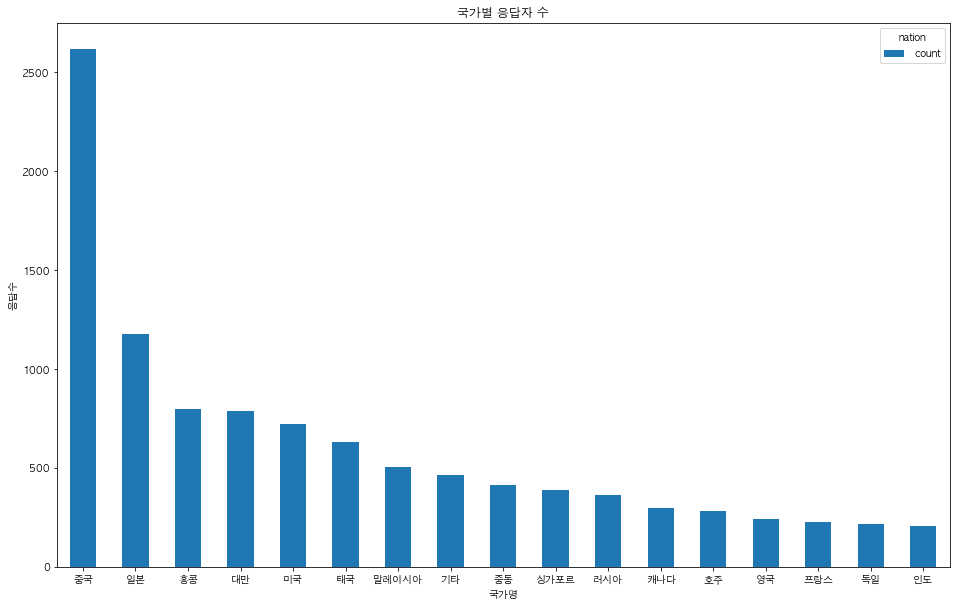

In [51]:
# 국가별 기술 통계

nation_stats = filter_non.copy()
nation_by = nation_stats[['NO', 'nat']]
nation_group_by = nation_by.groupby(nation_by['nat']).count()
nation_group_by = nation_group_by.sort_values('NO', ascending=False)

nation_group_by.rename( columns = { "NO" : " count"},
                        index = {  1 : "일본"
                                 , 2 : "중국"
                                 , 3 : "홍콩"
                                 , 4 : "싱가포르"
                                 , 5 : "대만"
                                 , 6 : "태국"
                                 , 7 : "말레이시아"
                                 , 8 : "호주"
                                 , 9 : "미국"
                                 , 10 : "캐나다"
                                 , 11 : "영국"
                                 , 12 : "독일"
                                 , 13 : "프랑스"
                                 , 14 : "러시아"
                                 , 15 : "중동"
                                 , 16 : "인도"
                                 , 97 : "기타"
                                }, inplace = True)


nation_group_by.columns.name = 'nation'
nation_group_by
# nation_group_by.describe()

nation_group_by.plot.bar(rot=0, figsize=(16,10))
plt.title("국가별 응답자 수")
plt.xlabel("국가명")
plt.ylabel("응답수")
plt.show()